# Fall 2024 - DATSC 701 Julie Wojtiw-Quo
# Isolation Forests and Air Quality:
#  A Case Study on Montreal

## The Problem:

Modelling air quality patterns in Montreal and identifying any anomalies across the city.

## Dataset:

The dataset, ACES_Montreal, involves data collected with the Atmospheric Composition and Environmental Survey platform
- The data involved mobile surveys
- The data was collected in October 2023 
    - Oct 16 through Oct 21
> Technical details: a LI-COR LI-7810 and an Airmar 220-WX weather station 
>
> LI-COR LI-7810 = measures atmosphereic CH4 (methane), CO2 (carbon dioxide), H20 (water vapour/ dihydrogen monoxide) mole fractions 
>
> Airmar 220-WX = measures GPS coords and weather conditions, ie air temperature, pressure, wind condition
- Data is collected every second, with time corrections accounting for inlet delay
- 26 variables

Relevant Variables
| variable | description |
| ------- | -------- |
| ch4d | ambient air CH4 (methane) dry mole fraction in ppm |
| co2d | ambient air CO2 (carbon dioxide) dry mole fraction in ppm |
| cod | ambient air CO (carbon monoxide) dry mole fraction in ppm |


Other Variables (not associated with mole fractions) 
| variable | description |
| --------- | --------- | 
| `gps_time` | the time of GPS in UTC (YYYY-MM-DD hh:mm:ss.sss) |
| `alt` |  the altitude in (m) meters above sea level |
| `lat` | the latitude in decimal degrees (+ = N) |
| `lon` | the longitude in decimal degrees (+ = E) |
| `pressure` | the ambient air pressure in hPa (h pascals) |

## Exploratory Data Analysis (EDA):

In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
folder_path = r".\ACES_Montreal_2023/ACES_Montreal_2023"

files = [os.path.join(path, file) for (path, dirs, files) in os.walk(folder_path) for file in files]

dfs = []

for file in files:
    print(f'FILE: {os.path.basename(file).split(".")[0]}')
    if os.path.basename(file).split(".")[-1] == "csv":
        dfs.append(pd.read_csv(file))


all_days_df = pd.concat(dfs)

FILE: readme
FILE: sync_data_calibrated_2023-10-16


FILE: sync_data_calibrated_2023-10-17
FILE: sync_data_calibrated_2023-10-18
FILE: sync_data_calibrated_2023-10-19
FILE: sync_data_calibrated_2023-10-20
FILE: sync_data_calibrated_2023-10-21


In [3]:
print(all_days_df.head())
print(all_days_df.shape)
print(all_days_df.columns.to_list())

                     gps_time    alt      amb  ch4      ch4d  co  co2  \
0  2023-10-16 14:15:38.300000  191.5  54.4998  NaN  2.026653 NaN  NaN   
1  2023-10-16 14:15:39.300000  191.8  54.4998  NaN  2.026559 NaN  NaN   
2  2023-10-16 14:15:40.300000  191.9  54.4998  NaN  2.026597 NaN  NaN   
3  2023-10-16 14:15:41.300000  192.1  54.4998  NaN  2.026519 NaN  NaN   
4  2023-10-16 14:15:42.300000  192.5  54.4998  NaN  2.026557 NaN  NaN   

         co2d  cod    cog  ...  pressure      rd1  rd2  sog       t  temp  \
0  419.440938  NaN   10.1  ...     986.0  12.6334  NaN  0.0  55.001  11.0   
1  419.403558  NaN  221.6  ...     986.0  12.6334  NaN  0.0  55.001  11.0   
2  418.158538  NaN   99.9  ...     986.1  12.6334  NaN  0.0  55.001  11.0   
3  418.896988  NaN  353.7  ...     986.1  12.6336  NaN  0.0  55.001  11.0   
4  418.128328  NaN   48.7  ...     986.1  12.6338  NaN  0.0  55.001  11.0   

   wd_corr  wd_uncorr  ws_corr  ws_uncorr  
0    338.1      276.4      3.4        7.0  
1    355.7

After concatenating all of the data, there are indeed 26 variables, and there are 177,764 data points.

In [4]:
print(all_days_df['gps_time'].describe())

count                         177764
unique                        177426
top       2023-10-21 14:00:00.300000
freq                              86
Name: gps_time, dtype: object


In [5]:
gps_time_vals = all_days_df['gps_time'].value_counts(dropna=False)
print(f'Number of gps_time that occur more than once: {len(gps_time_vals[gps_time_vals > 1])}')
print(f"Number of gps_time that occur more than twice:")
print(gps_time_vals[gps_time_vals > 2])

Number of gps_time that occur more than once: 56
Number of gps_time that occur more than twice:
gps_time
2023-10-21 14:00:00.300000    86
2023-10-19 19:26:42.500000    62
2023-10-19 19:28:29.300000    58
2023-10-17 18:56:43.000000    53
2023-10-17 15:04:48.300000    18
2023-10-21 01:44:05.500000    16
2023-10-19 12:21:19.900000     3
Name: count, dtype: int64


Interestingly, there are only 177,426 unique gps_time recordings, indicating that there are some GPS times that have duplicate data points recorded. On October 21 at 2pm, there are 86 simultaneous recordings. There are also some simultaneous recordings (greater than two recordings taken at the same timestep) on October 19th and October 17th.

In [6]:
print(all_days_df['lat'].describe())
print(all_days_df['lon'].describe())

count    177764.000000
mean         45.307415
std           0.533330
min          43.729040
25%          45.424100
50%          45.505720
75%          45.570140
max          45.833410
Name: lat, dtype: float64
count    177764.000000
mean        -74.309790
std           1.524528
min         -79.469810
25%         -73.937700
50%         -73.631870
75%         -73.575760
max         -73.484100
Name: lon, dtype: float64


Plotting the latitude versus the longitude with their frequency, a few locations also have more frequent recordings than others. This may be due to the sensors being stationary when starting and stopping the recording of the data.

![image](./media/Figure_2_lat_lon.png)

A 3-dimensional plot can be constructed using latitude, longitude and a predictor variable, such as co2d as seen here. This can begin to show where the points are clustering and can visually be inspected for any anomalies. There do not seem to be many co2d readings above 600 ppm, so this may be a good identifier for the verification/validation of isolated data points.

![image](./media/Figure_3_lat_lon_3d.png)

Another look can be taken by plotting a predictor variable, such as co2d, against latitude and longitude individually.

Latitude:

![image](./media/co2d_lat_1_0.png)

Longitude:

![image](./media/co2d_lon_1_0.png)

Interestingly, there are two peaks for both latitude and longitude. This needs to be investigated further on a map and/or with some domain knowledge on the latitudes and longitudes that Montreal exists within. 

Looking at the co2d levels, there appears to be a skew towards lower concentrations, with higher frequencies around 400-500 ppm of co2d and the frequency tapering off as the concentration grows. This is expected of the data.

In [ ]:
# Here, a GeoPandas dataframe is created to better handle 
# the lat/lon coordinates as Point and Geometry types.
# assuming GPS Coordinates are in WGS84 CRS (EPSG: 4326)
# This assumption is made since lat/lon coordinates are most
# often in WGS 84 / EPSG: 4326.
gdf = gpd.GeoDataFrame(all_days_df,
                       geometry=gpd.points_from_xy(all_days_df.lon, all_days_df.lat),
                       crs="EPSG:4326")


In [8]:
print(gdf.head())

                     gps_time    alt      amb  ch4      ch4d  co  co2  \
0  2023-10-16 14:15:38.300000  191.5  54.4998  NaN  2.026653 NaN  NaN   
1  2023-10-16 14:15:39.300000  191.8  54.4998  NaN  2.026559 NaN  NaN   
2  2023-10-16 14:15:40.300000  191.9  54.4998  NaN  2.026597 NaN  NaN   
3  2023-10-16 14:15:41.300000  192.1  54.4998  NaN  2.026519 NaN  NaN   
4  2023-10-16 14:15:42.300000  192.5  54.4998  NaN  2.026557 NaN  NaN   

         co2d  cod    cog  ...      rd1  rd2  sog       t  temp  wd_corr  \
0  419.440938  NaN   10.1  ...  12.6334  NaN  0.0  55.001  11.0    338.1   
1  419.403558  NaN  221.6  ...  12.6334  NaN  0.0  55.001  11.0    355.7   
2  418.158538  NaN   99.9  ...  12.6334  NaN  0.0  55.001  11.0    355.2   
3  418.896988  NaN  353.7  ...  12.6336  NaN  0.0  55.001  11.0    341.1   
4  418.128328  NaN   48.7  ...  12.6338  NaN  0.0  55.001  11.0    332.2   

   wd_uncorr  ws_corr  ws_uncorr                    geometry  
0      276.4      3.4        7.0  POINT (

## Geographic Mapping

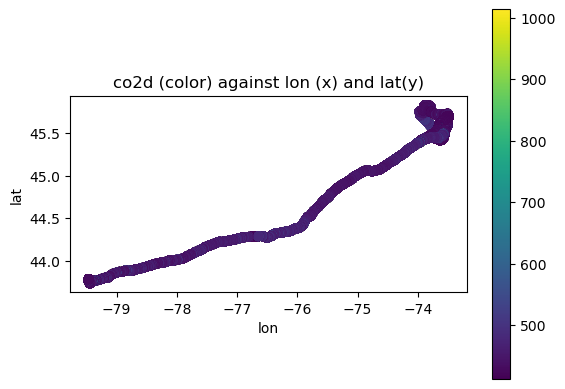

In [9]:
gdf.plot("co2d", legend=True)
plt.title("co2d (color) against lon (x) and lat(y)")
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

If the above plot does not render, see this '[map_of_lat_lon](./media/map_of_lat_lon.png)' image of the path of sensor recordings taken (ie, here the variable "co2d" is plotted against latitude on the y-axis and longitude on the x-axis)

![image](./media/map_of_lat_lon.png)

When first plotting any given predictor variable (here, co2d) versus latitude and longitude, the path taken seems confusing. The longitudes are much more widespread than the city of Montreal. At this point, a shapefile of Montreal was obtained in order to better locate the data points against real world locations.

<Axes: >

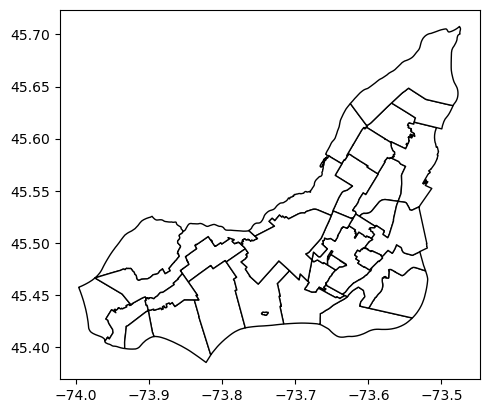

In [10]:
MONTREAL = f'./limites-administratives-agglomeration/limites-administratives-agglomeration.shp'
montreal_map = gpd.read_file(MONTREAL)
montreal_map.plot(color="white", edgecolor='black')

This shapefile, taken from the Canadian Open Government [portal](https://open.canada.ca/data/en/dataset/9797a946-9da8-41ec-8815-f6b276dec7e9/resource/f31d0036-a783-405d-9501-893dbe495e96), outlines Montreal's boroughs and related cities. See '[empty_montreal_boroughs](./media/empty_montreal_boroughs_.png)' and/or the limites-administratives-agglomeration folder. Quebec's version is found [here](https://www.donneesquebec.ca/recherche/dataset/vmtl-limites-administratives-agglomeration).

![image](./media/empty_montreal_boroughs_.png)

Plotting...


c:\Users\julie\.conda\envs\geo\Lib\site-packages\geopandas\geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 177764 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


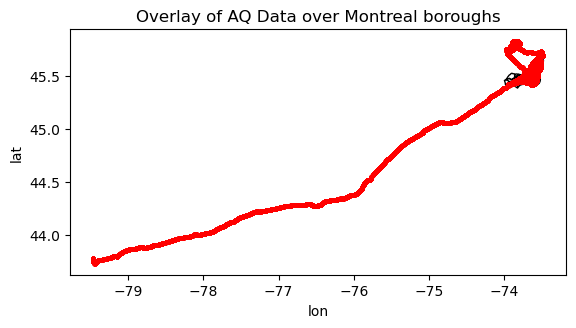

In [20]:
print("Plotting...")
test_overlay = montreal_map.overlay(gdf, how='union')
ax = test_overlay.plot(alpha=0.5, cmap='tab10')

montreal_map.plot(ax=ax, color="white", edgecolor="black")
gdf.plot(ax=ax, marker='o', color='red', markersize=3)

plt.title(f'Overlay of AQ Data over Montreal boroughs')
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

When overlayed, it can be seen that the map of the boroughs is small and located in the top right, indicating that the sensor readings were taken on a path to Montreal.

![image](./media/montreal_co2d_v0_2.png)

Plotting on an interactive HTML map using Folium, it becomes clear that the sensor readings follow the highway. Attempts were made to embed the HTML into the Jupyter notebook (using IPython.display in Python cell blocks and HTML code importing in markdown), but unfortunately rendering the interactive HTML map was more difficult than anticipated. See the '[full_co2d_map.html](./media/full_co2d_map.html)' to explore the interactive map.

In [ ]:

a = gdf.explore(column="co2d", cmap="YlOrRd")
outfp = './media/co2d_map.html'
a.save(outfp)


<div> 
    <!-- <object type="text/html" data="./media/full_co2d_map.html" width=1500px" height="600px" style="overflow:auto;border:5px ridge blue">
    </object> -->
    <iframe src="./media/full_co2d_map.html" style="overflow:auto" ></iframe>
 </div>

 

A screenshot of the Folium map follows:

![image](./media/folium_map_large_1_0.png)

The map of the data across all 6 days indicates that the sensors started tracking data in Toronto and then travelled along the highway until they reached Montreal. They followed the roads and highways, indicating that they were likely located on a moving vehicle.

After cutting the longitude down by selecting only the points within the Montreal boroughs, the following map is left [see 'montreal_co2d_v1_0'](./media/montreal_co2d_v1_0.png). Using a latitude and longitude cutoff for the bounds of Montreal was considered, but since the boroughs of Montreal may contain more or less than the desired area, a convex hull of the shapefile was used instead.

![image](./media/montreal_co2d_v1_0.png)


In [ ]:
# First, the CRS was identified and ensured to be the same between the
# air quality data set and the borough map data
print(f'Montreal SHP CRS: {montreal_map.crs}')
print(f'AQ CRS: {gdf.crs}')

gdf = gdf.to_crs(montreal_map.crs)


full_montreal = montreal_map.dissolve()
print(full_montreal.head())

## Other ways of validating the overlap in data is correct:
# inside = gdf.within(full_montreal)
# print(inside.value_counts())

# inside2 = full_montreal.contains(gdf)
# print(inside2.value_counts())

montreal_bounds = full_montreal.bounds
print(montreal_bounds)


# note: op parameter is replaced with `predicate`
montreal_only_gdf = gpd.sjoin(gdf, full_montreal, predicate = "within")
print(montreal_only_gdf.shape)


Montreal SHP CRS: EPSG:4326
AQ CRS: EPSG:4326
                                            geometry  CODEID      NOM  \
0  POLYGON ((-73.84293 45.39574, -73.84501 45.396...      10  LaSalle   

  NOM_OFFICI CODEMAMH CODE_3C  NUM ABREV            TYPE  \
0    LaSalle    REM17     LAS   18    LS  Arrondissement   

                                             COMMENT   DATEMODIF  
0  Il est important de noter que la limite située...  2023-11-29  
        minx       miny       maxx      maxy
0 -73.996602  45.385403 -73.473865  45.70758
(127068, 38)


Plotting...


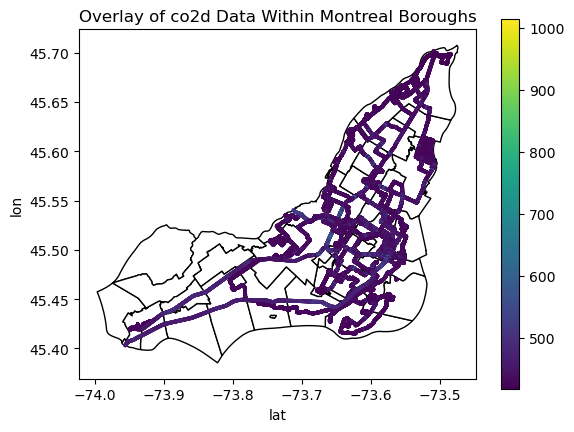

In [23]:
print("Plotting...")
base = montreal_map.plot(color="white", edgecolor="black")
montreal_only_gdf.plot("co2d",ax=base, marker='o', markersize=3, legend=True)

plt.title(f'Overlay of co2d Data Within Montreal Boroughs')
plt.xlabel("lat")
plt.ylabel("lon")

plt.show()

After investigating the map closer, it becomes clear that there are some areas neighbourhoods where the sensors gathered more data, and others that are very sparse; the data collected does not cover the entire city of Montreal.

Although no co2d data is missing, see '[aq_in_montreal.png](./media/aq_in_montreal.png)' for a more general plot of the data within Montreal bounds (useful to show points where co2d had missing data if that were the case).

Wrapping up the exploration of the data, some tests for what might be an outlier can be performed just by plotting the extreme values of predictor variables. Earlier, it was identified visually that not many data points for co2d reside above 600ppm, so this can be plotted on the map for further investigation.

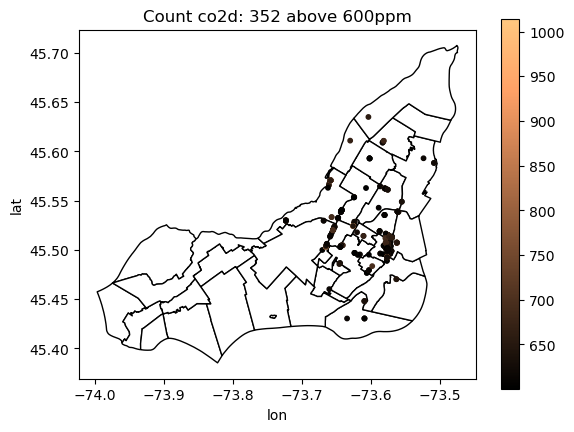

In [25]:
# Using 600ppm as previously identified
n = 600
base = montreal_map.plot(color="white", edgecolor="black")

outliers = montreal_only_gdf[montreal_only_gdf["co2d"] >= n]
outliers.plot("co2d", ax=base, marker='o', markersize=10, legend=True, cmap="copper")

plt.title(f'Count co2d: {outliers["co2d"].count()} above {n}ppm')
plt.xlabel("lon")
plt.ylabel("lat")

plt.show()

After plotting the co2d above 600ppm, only 352 data points are left. The points are also clustered around a few boroughs in Montreal.

Other values can also be looked at; here co2d values are plotted above 500ppm and above 800ppm


Above 500:

![image](./media/montreal_co2d_above500_v1_2.png)


Above 800:

![image](./media/montreal_co2d_above800_v1_3.png)

A few patterns and areas of interest emerge, but further analysis is needed. At higher concentrations, very few readings are taken. It is assumed that all data readings are accurate, and any anomalies in the data are true anomalies, rather than due to faulty equipment or false sensor readings.

Overall, this exploration provides a good starting base for comparison with the isolation forest results. Without further domain knowledge, it is difficult to compare further outlier possibilities. The isolation forest model will be put to the test to determine whether the current hypothesis that higher concentrations are more likely to be outliers is true.

## Isolation Forest

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

These first isolation forests show that there are a few hot spots around a park in Montreal. Further investigation revealed that this park is a mountain, with an elevation of []

Next, the relationship between these isolated anomalies will be compared with hour of day to look for any peak hour anomalies.

## Future Work

There are other datasets collected in a similar matter, using the ACES, in Toronto (2023) and Ottawa (2022). Future work could involve analyzing and comparing this data to the data from Montreal. The data from all three datasets could also be combined in order to look at air quality across the lower Ontario area.

Other datasets could be explored, including the daily air quality and air quality index (AQI) data released by ECCC (Environment and Climate Change Canada). Including other variables may expose more information about the air quality, especially when combined with domain knowledge on which air particles affect air quality the most.

Future investigations could also be done on the relationship between air quality and health incidents. Gathering health-related data could be challenging due to the confidentiality and ethicality involved in health data. However, even comparing the number of hospital or emergency room visits with the level of air quality could expose relationships between human health and air quality.